#### https://github.com/huggingface/transformers/issues/876

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Capstone_Project"
!ls

/content/drive/MyDrive/Capstone_Project
annotations
checkpoints
COCO_train2014_000000581909.jpg
compare_nlp_models_v1.ipynb
compare_nlp_models_v2.ipynb
error
image_captioning_3_model_train_test_mscoco2014_10k_data.ipynb
image_captioning_3_model_train_test_mscoco2014_1k_data.ipynb
image_captioning_3_model_train_test_mscoco2014_20k_data_100_epoch.ipynb
image_captioning_3_model_train_test_mscoco2014_20k_data_150_epoch.ipynb
image_captioning_3_model_train_test_mscoco2014_20k_data_300_epoch.ipynb
image_captioning_3_model_train_test_mscoco2014_20k_data_50_epoch.ipynb
image_captioning_3_model_train_test_mscoco2014_20k_data.ipynb
image_captioning_3_model_train_test_mscoco2014_50k_data.ipynb
image_captioning_load_model_text_similarity_v2.ipynb
image_captioning_load_model_text_similarity_v3.ipynb
materials
nlp_models
old
output_10k
output_1k
output_20k
output_20k_100_epoch
output_20k_150_epoch
output_20k_20_epoch
output_20k_300_epoch
output_20k_50_epoch
output_50k
output_nlp
sentence_similarity_

In [ ]:
!pip install -q sentence_transformers
!pip install -q sentence_transformers
!pip install -q huggingface-hub
!pip install datasets

     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 4.0 MB 27.5 MB/s 
     |████████████████████████████████| 1.2 MB 57.2 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 895 kB 59.9 MB/s 
     |████████████████████████████████| 6.6 MB 56.3 MB/s 
     |████████████████████████████████| 596 kB 77.0 MB/s 
     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.4 MB/s 
     |████████████████████████████████| 212 kB 71.6 MB/s 
     |████████████████████████████████| 136 kB 71.5 MB/s 
     |████████████████████████████████| 127 kB 68.4 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 70.1 MB/s 
     |████████████████████████████████| 271 kB 83.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully unins

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint

In [ ]:
# https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads

nlp_models_path = "./nlp_models/"

# model_names = ["all-MiniLM-L6-v2",
#                "paraphrase-MiniLM-L6-v2",
#                "LaBSE",
#                "paraphrase-multilingual-MiniLM-L12-v2",
#                "bert-base-nli-mean-tokens"]

model_names = [nlp_models_path + "all-MiniLM-L6-v2",
               nlp_models_path + "paraphrase-MiniLM-L6-v2",
               nlp_models_path + "LaBSE",
               nlp_models_path + "paraphrase-multilingual-MiniLM-L12-v2",
               nlp_models_path + "bert-base-nli-mean-tokens",
               "./output_nlp/sbert_test_b"]
models = []

for i in range(len(model_names)):
  model = SentenceTransformer(model_names[i])
  # model.save(nlp_models_path + model_names[i])
  models.append(model)

In [ ]:
from transformers import BertTokenizer, BertModel


model_path = './output_nlp/sbert_test_a'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

model_names.append(model_path)
models.append(model)

import numpy as np
import torch

cos_sim = torch.nn.CosineSimilarity()


def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

# build embeddings and calculate cosine similarity
def sts_process(sentence_a, sentence_b, model):
    vecs = []  # init list of sentence vecs
    for sentence in [sentence_a, sentence_b]:
        # build input_ids and attention_mask tensors with tokenizer
        input_ids = tokenizer(
            sentence, max_length=512, padding='max_length',
            truncation=True, return_tensors='pt'
        )
        # process tokens through model and extract token embeddings
        token_embeds = model(**input_ids).last_hidden_state
        # mean-pool token embeddings to create sentence embeddings
        sentence_embeds = mean_pool(token_embeds, input_ids['attention_mask'])
        vecs.append(sentence_embeds)
    # calculate cosine similarity between pairs and return numpy array
    return cos_sim(vecs[0], vecs[1]).detach().numpy()

In [ ]:
from datasets import load_dataset

snli_val = load_dataset("snli", split="validation")

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Dataset snli downloaded and prepared to /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b. Subsequent calls will reuse this data.


In [ ]:
# print(type(snli_val))

sentences_similar = []
sentences_dissimilar = []

NUM_ENTRIES = 100

for i in range(3 * NUM_ENTRIES):
  # print(snli_val[i])
  if snli_val[i]['label'] == 0:
    sentences_similar.append([snli_val[i]['premise'], snli_val[i]['hypothesis']])
  elif snli_val[i]['label'] == 2:
    sentences_dissimilar.append([snli_val[i]['premise'], snli_val[i]['hypothesis']])

print(sentences_similar)
print(sentences_dissimilar)
print(len(sentences_similar))
print(len(sentences_dissimilar))

[['Two women are embracing while holding to go packages.', 'Two woman are holding packages.'], ['Two young children in blue jerseys, one with the number 9 and one with the number 2 are standing on wooden steps in a bathroom and washing their hands in a sink.', 'Two kids in numbered jerseys wash their hands.'], ['A man selling donuts to a customer during a world exhibition event held in the city of Angeles', 'A man selling donuts to a customer.'], ['Two young boys of opposing teams play football, while wearing full protection uniforms and helmets.', 'boys play football'], ['A man in a blue shirt standing in front of a garage-like structure painted with geometric designs.', 'A man is wearing a blue shirt'], ['Under a blue sky with white clouds, a child reaches up to touch the propeller of a plane standing parked on a field of grass.', 'A child is reaching to touch the propeller of a plane.'], ['A woman is doing a cartwheel while wearing a bikini in the sand next to the beach.', 'A woman 

In [ ]:
sentence_embeddings_similar_dict = {}
sentence_embeddings_dissimilar_dict = {}

for i in range(len(model_names)-1):
  temp = []
  for j in range(len(sentences_similar)):
    temp.append(models[i].encode(sentences_similar[j]))
  sentence_embeddings_similar_dict[model_names[i]] = temp

for i in range(len(model_names)-1):
  temp = []
  for j in range(len(sentences_dissimilar)):
    temp.append(models[i].encode(sentences_dissimilar[j]))
  sentence_embeddings_dissimilar_dict[model_names[i]] = temp

print(f"Number of models: {len(model_names)}")
print(len(sentence_embeddings_similar_dict[model_names[0]]))
print(len(sentence_embeddings_dissimilar_dict[model_names[0]]))

Number of models: 7
96
103


In [ ]:
similarity_score_dict = {}

for i in range(len(model_names)):
  similarity_score_list = []
  
  for j in range(len(sentences_similar)):

    if i == (len(model_names) - 1):
      similarity_score = sts_process(sentences_similar[j][0], sentences_similar[j][1], model)[0]
    else:
      similarity_score = cosine_similarity(sentence_embeddings_similar_dict[model_names[i]][j][0].reshape(1, -1), sentence_embeddings_similar_dict[model_names[i]][j][1].reshape(1, -1))[0][0]
    similarity_score_list.append(similarity_score)
    # pprint('Similarity between \"{}\" and \"{}\" is {} using model: {}'.format(sentences_similar[j][0],
    #    sentences_similar[j][1],
    #    similarity_score,
    #    model_names[i]))
  similarity_score_dict[model_names[i]] = similarity_score_list

print(similarity_score_dict)

# ---------------------------------------------------------------------------------------------------
dissimilarity_score_dict = {}

for i in range(len(model_names)):
  dissimilarity_score_list = []
  
  for j in range(len(sentences_dissimilar)):
    if i == (len(model_names) - 1):
      dissimilarity_score = sts_process(sentences_dissimilar[j][0], sentences_dissimilar[j][1], model)[0]
    else:
      dissimilarity_score = cosine_similarity(sentence_embeddings_dissimilar_dict[model_names[i]][j][0].reshape(1, -1), sentence_embeddings_dissimilar_dict[model_names[i]][j][1].reshape(1, -1))[0][0]
    dissimilarity_score_list.append(dissimilarity_score)
    # pprint('Similarity between \"{}\" and \"{}\" is {} using model: {}'.format(sentences_dissimilar[j][0],
    #    sentences_dissimilar[j][1],
    #    dissimilarity_score,
    #    model_names[i]))
  dissimilarity_score_dict[model_names[i]] = dissimilarity_score_list

print(dissimilarity_score_dict)

{'./nlp_models/all-MiniLM-L6-v2': [0.76151633, 0.72763896, 0.783048, 0.803669, 0.59987295, 0.71360534, 0.71062726, 0.5971346, 0.6739005, 0.6534971, 0.38489512, 0.78963023, 0.86674637, 0.6975223, 0.979381, 0.93998855, 0.6542733, 0.7823913, 0.63272476, 0.68938756, 0.5880819, 0.33621925, 0.5403187, 0.61124545, 0.6161736, 0.46105355, 0.79810894, 0.9298937, 0.88657403, 0.78977406, 0.47564548, 0.5049777, 0.6905295, 0.74494916, 0.43876034, 0.674561, 0.4331931, 0.6040896, 0.7454449, 0.60846364, 0.63725686, 0.6161336, 0.5703298, 0.41579568, 0.91933477, 0.7703618, 0.96205294, 0.58774865, 0.6329814, 0.5424336, 0.6744543, 0.5540624, 0.78624034, 0.62698364, 0.81052077, 0.6391883, 0.95690286, 0.5427029, 0.7272153, 0.6660576, 0.8331811, 0.45408875, 0.6915183, 0.63890237, 0.63864994, 0.5602908, 0.42470732, 0.79056567, 0.6602833, 0.8469702, 0.7721958, 0.67632437, 0.7026999, 0.4882266, 0.50931835, 0.9977764, 0.90618175, 0.8317301, 0.67559445, 0.7171993, 0.8520301, 0.33162433, 0.7605568, 0.6092531, 0.496

In [ ]:
import pandas as pd

df_similar = pd.DataFrame(similarity_score_dict)
df_dissimilar = pd.DataFrame(dissimilarity_score_dict)

In [ ]:
df_similar

,./nlp_models/all-MiniLM-L6-v2,./nlp_models/paraphrase-MiniLM-L6-v2,./nlp_models/LaBSE,./nlp_models/paraphrase-multilingual-MiniLM-L12-v2,./nlp_models/bert-base-nli-mean-tokens,./output_nlp/sbert_test_b,./output_nlp/sbert_test_a
0,0.761516,0.802448,0.819890,0.775430,0.864785,0.771428,0.858764
1,0.727639,0.787500,0.602852,0.840839,0.678445,0.762457,0.792599
2,0.783048,0.854760,0.598355,0.927094,0.845174,0.825220,0.886017
3,0.803669,0.777568,0.500152,0.787946,0.855469,0.819836,0.868879
4,0.599873,0.684842,0.500475,0.674292,0.673711,0.650059,0.532525
...,...,...,...,...,...,...,...
91,0.704088,0.733395,0.621464,0.792933,0.685196,0.626790,0.837693
92,0.571842,0.556694,0.623473,0.502408,0.418696,0.401750,0.394299
93,0.614979,0.581915,0.705548,0.625909,0.673605,0.566768,0.888389
94,0.584636,0.467268,0.588840,0.475142,0.676764,0.785215,0.712294


In [ ]:
df_dissimilar

,./nlp_models/all-MiniLM-L6-v2,./nlp_models/paraphrase-MiniLM-L6-v2,./nlp_models/LaBSE,./nlp_models/paraphrase-multilingual-MiniLM-L12-v2,./nlp_models/bert-base-nli-mean-tokens,./output_nlp/sbert_test_b,./output_nlp/sbert_test_a
0,0.074186,0.004630,0.238242,-0.033536,0.007217,-0.054761,-0.485240
1,0.330629,0.390224,0.516300,0.381650,0.238097,0.282341,-0.024343
2,-0.018999,0.042277,0.209647,0.054110,0.373043,0.453697,0.366036
3,-0.003865,-0.051531,0.152060,-0.055300,0.091823,0.132740,-0.006588
4,0.299173,0.395348,0.420800,0.446505,0.550699,0.389955,0.645899
...,...,...,...,...,...,...,...
98,0.119102,0.164458,0.401571,0.162299,0.137026,0.183437,0.055310
99,0.420295,0.485038,0.605058,0.452142,0.528520,0.497263,0.718917
100,0.319567,0.361291,0.444456,0.164982,0.287144,0.342377,0.182060
101,0.588081,0.702202,0.666743,0.703631,0.467337,0.620370,0.780477


In [ ]:
comb_data = {"Mean Cosine similarity score of similar sentences" : df_similar.mean(),
             "Mean Cosine similarity score of dissimilar sentences" : df_dissimilar.mean()}
df_comb = pd.DataFrame(comb_data)
df_comb

,Mean Cosine similarity score of similar sentences,Mean Cosine similarity score of dissimilar sentences
./nlp_models/all-MiniLM-L6-v2,0.668136,0.303063
./nlp_models/paraphrase-MiniLM-L6-v2,0.694677,0.304168
./nlp_models/LaBSE,0.572388,0.445516
./nlp_models/paraphrase-multilingual-MiniLM-L12-v2,0.711657,0.311254
./nlp_models/bert-base-nli-mean-tokens,0.695206,0.331151
./output_nlp/sbert_test_b,0.668554,0.348047
./output_nlp/sbert_test_a,0.715974,0.231565


Text(0, 0.5, 'NLP Models')

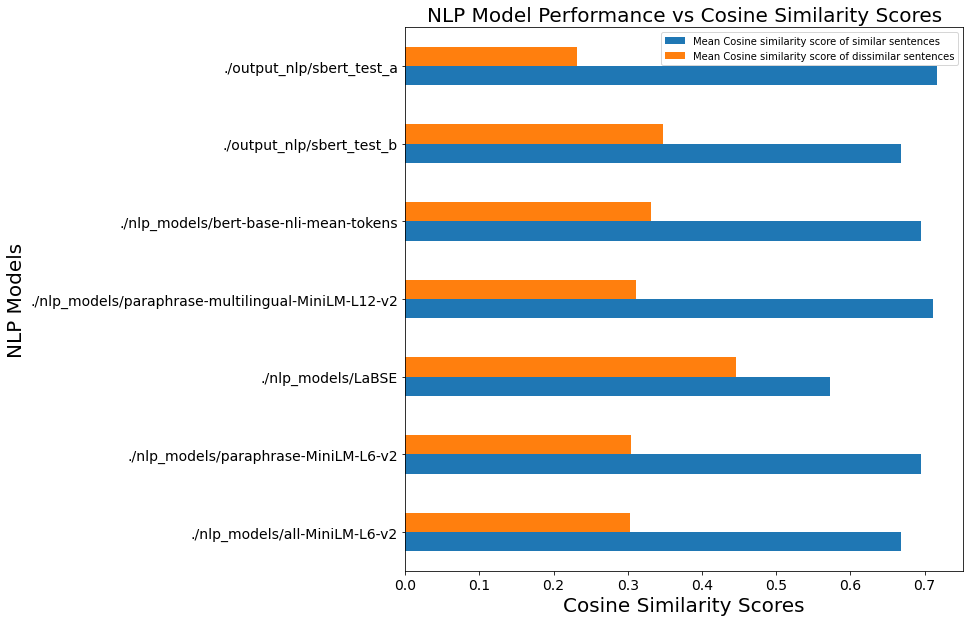

In [ ]:
ax = df_comb.plot(kind='barh', figsize=(10, 10), title="NLP Model Performance vs Cosine Similarity Scores", ylabel="Cosine Similarity Score", fontsize=14)
ax.title.set_size(20)
ax.set_xlabel("Cosine Similarity Scores", fontsize=20)
ax.set_ylabel("NLP Models", fontsize=20)